## 0. Introdução

Neste projeto, abordei a tarefa de segmentação de clientes por meio da aplicação do algoritmo KMeans, uma técnica de aprendizado de máquina não supervisionado amplamente reconhecida por sua eficácia na descoberta de padrões ocultos em conjuntos de dados. Ao aplicar o KMeans às métricas RFV, buscamos identificar grupos de clientes com comportamentos semelhantes, permitindo que a empresa adapte suas estratégias de marketing e atendimento de acordo com as necessidades específicas de cada segmento.

O principal objetivo deste projeto é oferecer uma visão abrangente de como a segmentação de clientes com base na análise RFV e a aplicação do algoritmo KMeans podem ser utilizadas de forma sinérgica para criar uma abordagem mais personalizada e direcionada ao gerenciamento de clientes. Ao identificar segmentos distintos, a empresa pode otimizar seus recursos, concentrando-se nas áreas de maior potencial e adaptando suas abordagens para melhor atender às expectativas e preferências dos clientes.

## 1. Importando bibliotecas e carregando os dados

In [1]:
# Manipulação e visualização de dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('bright')
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from datetime import datetime

# Modelos de clusterização
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Pré processamento
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Carregando dataset
data = pd.read_csv("C:/Users/joaoi/Cust_Seg_Project/data/raw/OnlineRetail.csv", encoding = 'unicode_escape')

#Excluindo registros com valores nulos
data.dropna(inplace = True)

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
print(f"Esse dataset possui {data.shape[0]} linhas e {data.shape[1]} colunas")

Esse dataset possui 406829 linhas e 8 colunas


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


### 1.1 Colunas

- <b> InvoiceNo</b>: Valor único para cada compra

- <b> StockCode</b>: Código do estoque

- <b> Description</b>: Descrição do produto

- <b> Quantity</b>: Quantidade de produtos comprados

- <b> InvoiceDate</b>: Data da compra

- <b> UnitPrice</b>: Preço por unidade de produto

- <b> CustomerID</b>: Identificador do cliente

- <b> Country</b>: País do comprador

In [5]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
# Excluindo a coluna de código de estoque, sem utilidade nesse caso
df = data.drop('StockCode', axis = 1)
df.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


## 2. Pré processamento

Através da função describe, é possível identificar que existem valores negativos da variável 'Quantity' e valores de zero para 'UnitPrice'. Ambas devem ser valores inteiros positivos diferentes de zero, portanto iremos excluir registros contendo esses erros por meio da função "query".

In [7]:
# Remove implicitamente registros com UnitPrice e Quantity iguais ou menores que zero
df = df.query("UnitPrice > 0 and Quantity > 0")

df.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [8]:
print(f"O novo dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas")

O novo dataset possui 397884 linhas e 7 colunas


### 2.1 Remoção de outliers

In [9]:
# Suponha que 'df' seja o seu DataFrame e as colunas sejam 'Quantity' e 'UnitPrice'
columns_to_check = ['Quantity', 'UnitPrice']

# Calculando os z-scores para as colunas selecionadas
z_scores = df[columns_to_check].apply(zscore)

# Definindo um limite para considerar um valor como outlier
z_score_threshold = 3

# Identificando os índices dos outliers
outlier_indices = (z_scores > z_score_threshold).any(axis=1)

# Filtrando o DataFrame original para remover os outliers
df_no_out = df[~outlier_indices]

print(f"O novo dataset (sem outliers) possui {df_no_out.shape[0]} linhas e {df_no_out.shape[1]} colunas")

O novo dataset (sem outliers) possui 397275 linhas e 7 colunas


### 2.2 Feature Engineering

Após o tratamento do dataset retirando valores que poderiam prejudicar o desenvolvimento do projeto, podemos agora criar uma nova variável "InvoiceRevenue" que representa o total gasto pelo cliente em cada compra.

In [10]:
# Criando a variável preço total do item
df_no_out.loc[:, 'InvoiceRevenue'] = df_no_out.loc[:, 'Quantity'] * df_no_out.loc[:, 'UnitPrice']

# Modificando variável InvoiceDate
df_no_out.loc[:, 'InvoiceDate'] = pd.to_datetime(df_no_out.loc[:, 'InvoiceDate'])

# Excluindo coluna antiga
df_no_out = df_no_out.drop(['Quantity', 'UnitPrice'], axis=1)

df_no_out.head()

,InvoiceNo,Description,InvoiceDate,CustomerID,Country,InvoiceRevenue
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2010-01-12 08:26:00,17850.0,United Kingdom,15.30
1,536365,WHITE METAL LANTERN,2010-01-12 08:26:00,17850.0,United Kingdom,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,2010-01-12 08:26:00,17850.0,United Kingdom,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2010-01-12 08:26:00,17850.0,United Kingdom,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,2010-01-12 08:26:00,17850.0,United Kingdom,20.34


## 3. Calculando valores RFM (Recency, Frequency e Monetary value)

As métricas RFV são uma ferramenta valiosa no campo do marketing e análise de dados, que permitem avaliar o desempenho e o valor dos clientes com base em três componentes fundamentais: Recência (R), Frequência (F) e Valor (V). Estas métricas são frequentemente utilizadas para segmentar e personalizar estratégias de marketing, ajudando as empresas a entenderem melhor seus clientes e tomar decisões mais informadas. Aqui está uma breve descrição de cada uma das métricas RFV:

- Recência (R): A métrica de Recência avalia o tempo desde a última interação ou compra de um cliente com sua empresa. Geralmente, quanto mais recente a interação, maior a pontuação de recência. Porém, para facilitar o processo de segmentação, optei por apenas fazer a recência em meses, subtraindo a data da última compra de todo o dataset pela data a última compra de cada cliente. Dessa forma a lógica fica invertida, quanto menor a recência, mais recente foi a última compra do cliente. Esse métrica é importante porque clientes que interagem mais recentemente podem estar mais envolvidos com sua marca e podem responder melhor a promoções ou mensagens personalizadas.

- Frequência (F): A métrica de Frequência mede com que frequência um cliente interage ou realiza compras com sua empresa ao longo de um determinado período. Clientes que fazem compras ou interagem com frequência mais alta geralmente são mais valiosos, pois demonstram fidelidade à sua marca. Em nosso caso, considerei todo o período do dataset para fazer o cálculo.

- Valor (V): A métrica de Valor se concentra no valor total que um cliente gasta em suas compras ao longo do tempo. Clientes que gastam mais representam um maior valor para a empresa e são frequentemente considerados como clientes VIP.

### 3.1 Recência

In [11]:
# Criando dataframe com cada cliente e a data e hora de sua última compra
df_recency = df_no_out.groupby('CustomerID')['InvoiceDate'].agg('max').reset_index()

df_recency

,CustomerID,InvoiceDate
0,12347.0,2011-10-31 12:25:00
1,12348.0,2011-09-25 13:13:00
2,12349.0,2011-11-21 09:51:00
3,12350.0,2011-02-02 16:01:00
4,12352.0,2011-09-28 14:58:00
...,...,...
4314,18280.0,2011-07-03 09:52:00
4315,18281.0,2011-12-06 10:53:00
4316,18282.0,2011-05-08 13:35:00
4317,18283.0,2011-11-30 12:59:00


In [12]:
max_time = df_recency['InvoiceDate'].max()

def month_diff(max_time, cust_max_time):
    "Retorna a diferença em meses entre a data da última compra e a última compra do cliente"
    return 12 * (max_time.year - cust_max_time.year) + (max_time.month - cust_max_time.month)

df_recency["Recency"] = df_recency.InvoiceDate.apply(
    lambda cust_max_time: month_diff(max_time, cust_max_time)
)

df_recency.head()

,CustomerID,InvoiceDate,Recency
0,12347.0,2011-10-31 12:25:00,2
1,12348.0,2011-09-25 13:13:00,3
2,12349.0,2011-11-21 09:51:00,1
3,12350.0,2011-02-02 16:01:00,10
4,12352.0,2011-09-28 14:58:00,3


### 3.2 Frequência

In [13]:
# Calculando frequência e criando dataframe com as frequências de cada cliente
df_frequency = df_no_out.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

df_frequency.columns = ['CustomerID', 'Frequency']

df_frequency.head()

,CustomerID,Frequency
0,12347.0,7
1,12348.0,4
2,12349.0,1
3,12350.0,1
4,12352.0,7


In [14]:
df_frequency.describe()

,CustomerID,Frequency
count,4319.000000,4319.000000
mean,15298.642741,4.254689
std,1721.412606,7.642029
min,12347.000000,1.000000
25%,13812.500000,1.000000
50%,15297.000000,2.000000
75%,16778.500000,5.000000
max,18287.000000,207.000000


### 3.3 Valor

In [15]:
# Calculando valor monetário e criando um dataframe com os valores de cada cliente
df_value = df_no_out.groupby("CustomerID")['InvoiceRevenue'].agg("sum").reset_index()

df_value.columns = ['CustomerID', 'Monetary']

df_value.head()

,CustomerID,Monetary
0,12347.0,4310.00
1,12348.0,1797.24
2,12349.0,1457.55
3,12350.0,334.40
4,12352.0,1665.74


### 3.4 Juntando datasets

In [16]:
# Juntando os DataFrames com base na coluna 'CustomerID'
merged_df = df_recency.merge(df_frequency, on='CustomerID', how='left').merge(df_value, on='CustomerID', how='left')

# Excluindo coluna 'InvoiceDate'
pre_df_rfv = merged_df.drop('InvoiceDate', axis = 1)

# Exibindo o DataFrame resultante
pre_df_rfv

,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,7,4310.00
1,12348.0,3,4,1797.24
2,12349.0,1,1,1457.55
3,12350.0,10,1,334.40
4,12352.0,3,7,1665.74
...,...,...,...,...
4314,18280.0,5,1,180.60
4315,18281.0,0,1,80.82
4316,18282.0,7,2,178.05
4317,18283.0,1,16,2094.88


## 4. Clusterização

Vários algoritmos (Hierarquical Clustering, DBSCAN, GMM, etc...) e diferentes transformações foram testadas, porém optei por deixar no notebook apenas a versão final para encurtar a leitura e escolhendo o KMeans para fazer a clusterização.

In [17]:
pre_df_rfv = pre_df_rfv.drop('CustomerID', axis = 1)

print(f"O novo dataset possui {pre_df_rfv.shape[0]} linhas e {pre_df_rfv.shape[1]} colunas")


O novo dataset possui 4319 linhas e 3 colunas


### 4.1 Escalonamento de features e visualização dos dados

Como vamos utilizar um algoritmo que se baseia em médias, é importante tomarmos cuidado com os outliers (valores discrepantes) que podem prejudicar a identificação dos clusters através do deslocamento dos centróides, que são "puxados" pelos datapoints mais distantes dos outros. Logo, é necessário evitar isso, o que será feito por meio da remoção dos registros que tenham uma das colunas com valores acima de 3 desvios-padrão da média, valor representado pelo z-score.

Após isso, iremos escalonar os dados para deixar todas as variáveis com mesmo peso dentro do dataframe.

In [18]:
# Colunas que serão checadas
columns_to_check = ['Recency', 'Frequency', 'Monetary']

# Calculando os z-scores para as colunas selecionadas
z_scores = pre_df_rfv[columns_to_check].apply(zscore)

# Definindo um limite para considerar um valor como outlier
z_score_threshold = 3

# Identificando os índices dos outliers
outlier_indices = (z_scores > z_score_threshold).any(axis=1)

# Filtrando o DataFrame original para remover os outliers
df_rfv = pre_df_rfv[~outlier_indices]

print(f"O novo dataset (sem outliers) possui {df_rfv.shape[0]} linhas e {df_rfv.shape[1]} colunas")


O novo dataset (sem outliers) possui 4186 linhas e 3 colunas


In [19]:
# Colunas do dataframe
feature_cols = ['Recency', 'Frequency', 'Monetary']

# Copiando dataframe de rfv
standardized_data = df_rfv.copy()

# Instanciando scaler
scaler = MinMaxScaler()

# Ajustando scaler aos dados
scaler.fit(df_rfv[feature_cols])

# Aplicando scaler no dataframe
standardized_data[feature_cols] = scaler.transform(df_rfv[feature_cols])

# Dataframe com os dados escalanados
standardized_data = standardized_data[feature_cols]

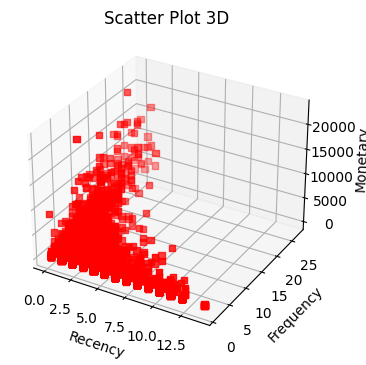

In [20]:
# Criando um gráfico 3D
fig = plt.figure(figsize=(10, 6))
ax_3d = fig.add_subplot(131, projection='3d')

# Scatter plot 3D
ax_3d.scatter(df_rfv['Recency'], df_rfv['Frequency'], df_rfv['Monetary'], c='r', marker=',')
ax_3d.set_xlabel('Recency')
ax_3d.set_ylabel('Frequency')
ax_3d.set_zlabel('Monetary')
ax_3d.set_title('Scatter Plot 3D')

plt.tight_layout()
plt.show()

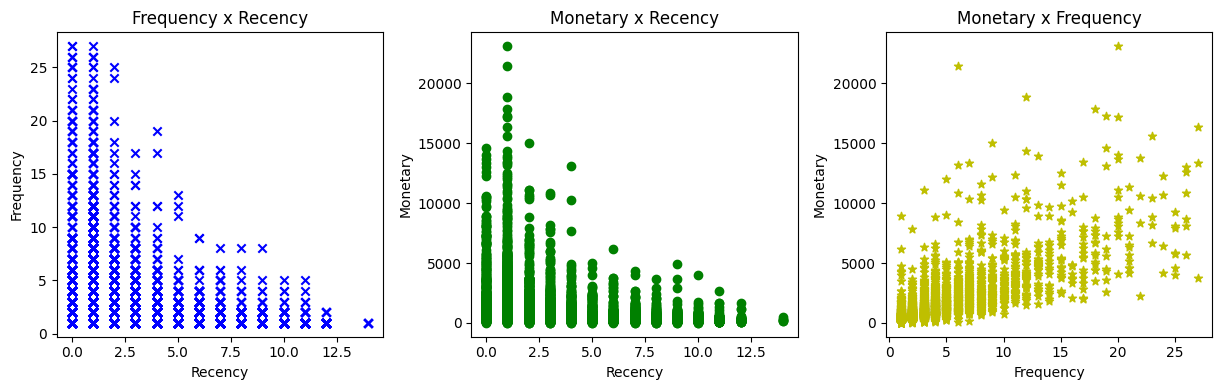

In [21]:
fig2 = plt.figure(figsize=(16, 4))

# Scatter plot Recency x Frequency
ax = fig2.add_subplot(142)
ax.scatter(df_rfv['Recency'], df_rfv['Frequency'], c='b', marker='x')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_title('Frequency x Recency')

# Scatter plot
ax2 = fig2.add_subplot(143)
ax2.scatter(df_rfv['Recency'], df_rfv['Monetary'], c='g', marker='o')
ax2.set_xlabel('Recency')
ax2.set_ylabel('Monetary')
ax2.set_title('Monetary x Recency')

# Scatter plot
ax3 = fig2.add_subplot(144)
ax3.scatter(df_rfv['Frequency'], df_rfv['Monetary'], c='y', marker='*')
ax3.set_xlabel('Frequency')
ax3.set_ylabel('Monetary')
ax3.set_title('Monetary x Frequency')

plt.tight_layout()
plt.show()


### 4.2 Definição do número de clusters

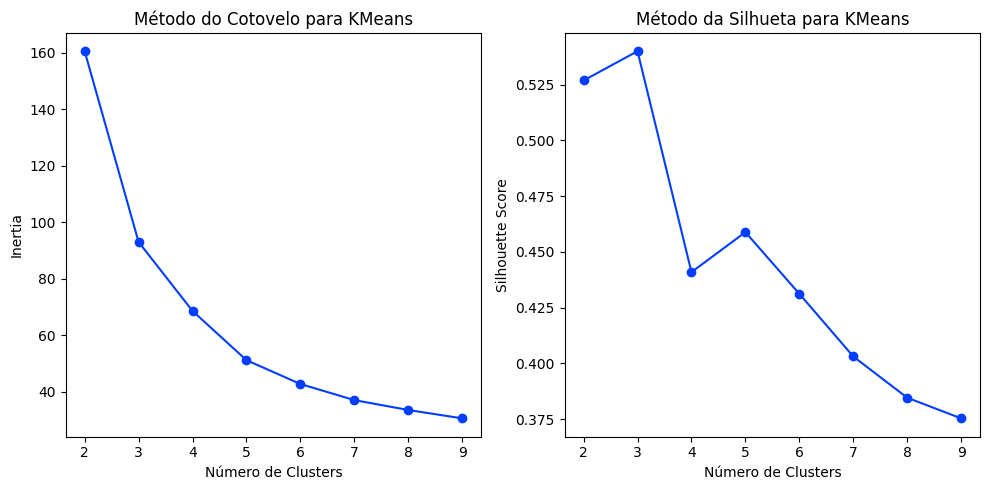

In [22]:
# Método do Cotovelo
# Teste diferentes valores de n_components
# Teste diferentes valores de n_clusters
n_clusters_range = range(2, 10)
inertia_scores = []
silhouette_scores = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(standardized_data)
    
    # Método do Cotovelo: Inertia (Within-Cluster Sum of Squares)
    inertia_scores.append(kmeans.inertia_)
    
    # Método da Silhueta
    labels = kmeans.predict(standardized_data)
    silhouette_avg = silhouette_score(standardized_data, labels)
    silhouette_scores.append(silhouette_avg)

# Plot da curva do método do cotovelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(n_clusters_range, inertia_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.title('Método do Cotovelo para KMeans')

# Plot da curva do método da silhueta
plt.subplot(1, 2, 2)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Método da Silhueta para KMeans')

plt.tight_layout()
plt.show()

Através da interpretação desses métodos,  optei por definir que o melhor número de clusters para o projeto é 5. 

Podemos verificar isso no método cotovelo por meio do comportamento da linha após o valor 4, uma sequência de diminuições lineares. Paralelamente, no método silhueta, o valor silhuette score é maior para o número de clusters 5 em relação aos demais (Excluindo 2 e 3). Além disso, creio que seja um número de mais fácil para classificar grupos e interpretá-los.

### 4.3 Clusterização com KMeans

In [23]:
# Criar uma instância do algoritmo KMeans
Kmeans = KMeans(n_clusters=5, random_state=44 )

# Ajustar o KMeans aos dados
Kmeans.fit(standardized_data)

# Obter os rótulos dos clusters
df_rfv.loc[:, 'Cluster'] = Kmeans.predict(standardized_data)

df_rfv.head()

,Recency,Frequency,Monetary,Cluster
0,2,7,4310.00,2
1,3,4,1797.24,0
2,1,1,1457.55,0
3,10,1,334.40,1
4,3,7,1665.74,2


In [24]:
# Número de clientes por cluster
df_rfv['Cluster'].value_counts()

0    1862
3     898
2     671
1     589
4     166
Name: Cluster, dtype: int64

### 4.4 Análise dos clusters

In [25]:
# Visualizando estatisticamente os clusters
df_rfv.groupby("Cluster").agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'Cluster' : 'count'
})

,Recency,Frequency,Monetary,Cluster
Cluster,,,,
0,1.600430,2.453813,834.637805,1862
1,9.573854,1.346350,425.137657,589
2,1.275708,7.952310,2992.114993,671
3,5.347439,2.071269,675.303588,898
4,0.728916,17.662651,7660.091807,166


Olhando para os valores de Recência, Frequência e Valor monetário médio de cada cluster, podemos inferir que:

<b> Cluster 0 - Cautelosos Compradores</b>:

- Recency Médio: 1.60
- Frequency Médio: 2.45
- Monetary Médio: R$834.64
- Descrição: Este grupo de clientes demonstra uma recência relativamente baixa em suas transações, indicando que não realizam compras com muita frequência. Sua frequência de compra e gasto monetário também são moderados, sugerindo um comportamento de consumo mais conservador.

<b> Cluster 1 - Compradores Esporádicos de Baixo Gasto</b>:

- Recency Médio: 9.57
- Frequency Médio: 1.35
- Monetary Médio: R$425.14
- Descrição: Os clientes deste cluster têm uma recência mais alta em suas compras, indicando que não interagem frequentemente com a empresa. Sua frequência de compra e gasto são relativamente baixos, sugerindo que são compradores esporádicos com um valor médio de transação modesto.

<b> Cluster 2 - Clientes Fieis de Alto Gasto</b>:

- Recency Médio: 1.28
- Frequency Médio: 7.95
- Monetary Médio: R$2992.11
- Descrição: Este grupo se destaca pela recência baixa e pela alta frequência de compra. Além disso, eles têm um gasto monetário substancial em suas transações, indicando um alto valor de cliente. Esses clientes são leais e estão dispostos a gastar mais para adquirir produtos ou serviços.

<b> Cluster 3 - Compradores Moderados</b>:

- Recency Médio: 5.35
- Frequency Médio: 2.07
- Monetary Médio: R$675.30
- Descrição: Os clientes neste cluster têm uma recência e frequência moderadas em suas compras. Seu gasto também é moderado, indicando um equilíbrio entre a frequência e o valor da transação.

<b> Cluster 4 - Compradores Frequentes de Alto Gasto</b>:

- Recency Médio: 0.73
- Frequency Médio: 17.66
- Monetary Médio: R$7660.09
- Descrição: Este grupo se destaca pela recência muito baixa, alta frequência de compra e gasto monetário substancial. São clientes extremamente ativos e valiosos para a empresa, provavelmente pertencendo a um segmento premium.

#### Visualizando os clusters

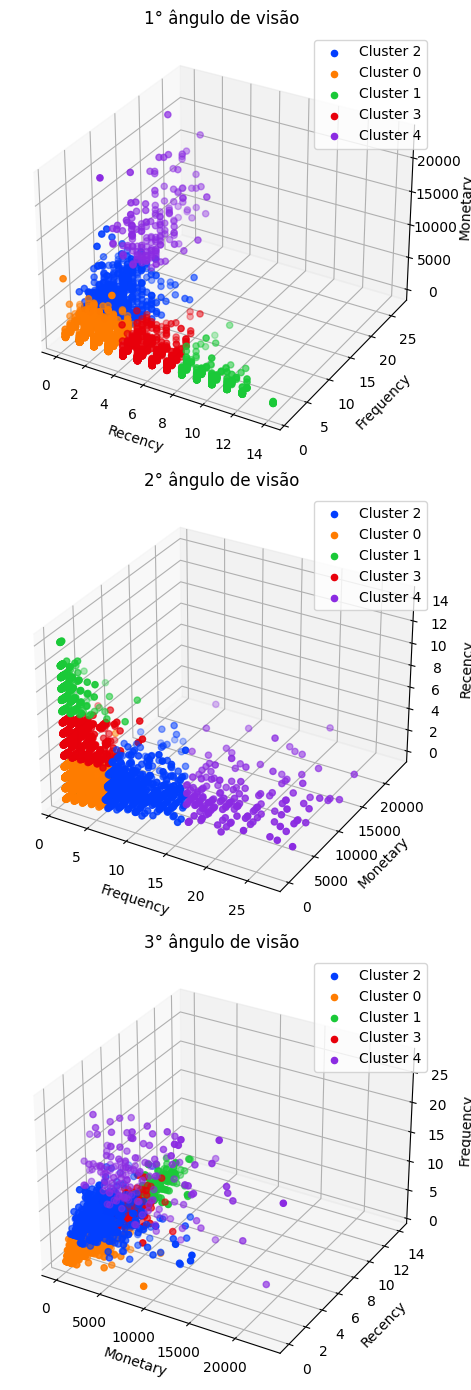

In [26]:
# Criando subplots em uma coluna e três linhas
fig, (ax_3d, ax_3dB, ax_3dC) = plt.subplots(3, 1, figsize=(12, 14), subplot_kw={'projection': '3d'})

# Definindo os nomes dos clusters (você pode ajustar de acordo com seus dados)
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

# Iterando pelos clusters e plotando os pontos
for cluster_id in df_rfv['Cluster'].unique():
    cluster_data = df_rfv[df_rfv['Cluster'] == cluster_id]
    
    # Primeiro Scatter plot 3D
    ax_3d.scatter(cluster_data['Recency'], cluster_data['Frequency'], 
     cluster_data['Monetary'], label=cluster_names[cluster_id], marker='o')
    ax_3d.set_xlabel('Recency')
    ax_3d.set_ylabel('Frequency')
    ax_3d.set_zlabel('Monetary')
    ax_3d.set_title('1° ângulo de visão')
    
    # Segundo scatter plot 3D
    ax_3dB.scatter(cluster_data['Frequency'], cluster_data['Monetary'], 
     cluster_data['Recency'], label=cluster_names[cluster_id], marker='o')
    ax_3dB.set_xlabel('Frequency')
    ax_3dB.set_ylabel('Monetary')
    ax_3dB.set_zlabel('Recency')
    ax_3dB.set_title('2° ângulo de visão')
    
    # Terceiro scatter plot 3D
    ax_3dC.scatter(cluster_data['Monetary'], cluster_data['Recency'],
     cluster_data['Frequency'], label=cluster_names[cluster_id], marker='o')
    ax_3dC.set_xlabel('Monetary')
    ax_3dC.set_ylabel('Recency')
    ax_3dC.set_zlabel('Frequency')
    ax_3dC.set_title('3° ângulo de visão')

# Adicionando a legenda
ax_3d.legend()
ax_3dB.legend()
ax_3dC.legend()

plt.tight_layout()
plt.show()

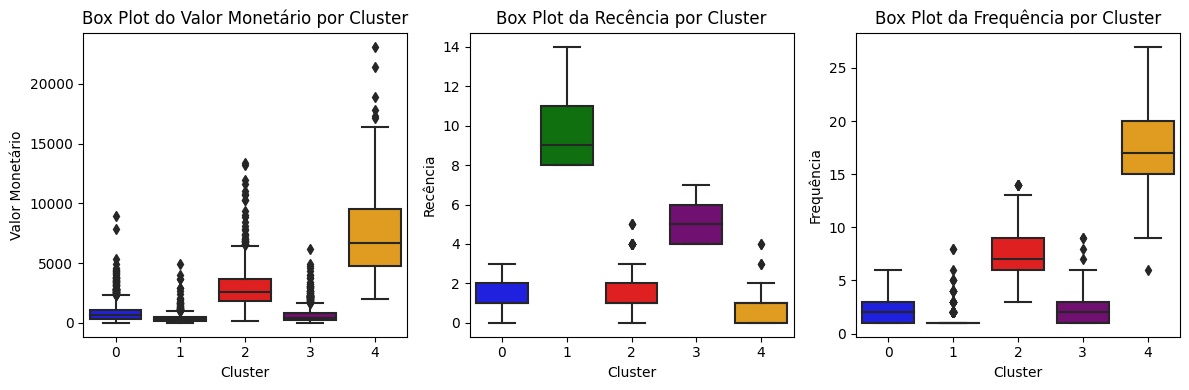

In [27]:
# Definindo as cores
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Adicione mais cores se necessário

# Criando figura
fig = plt.figure(figsize=(12, 4))

# Adicionando subplots
clus_val = fig.add_subplot(131)
clus_rec = fig.add_subplot(132)
clus_fre = fig.add_subplot(133)

# Primeiro gráfico - Boxplot do Valor Monetário por Cluster
sns.boxplot(data=df_rfv, x='Cluster', y='Monetary', ax=clus_val, palette=colors)
clus_val.set_title('Box Plot do Valor Monetário por Cluster')
clus_val.set_xlabel('Cluster')
clus_val.set_ylabel('Valor Monetário')

# Segundo gráfico - Boxplot da Recência por Cluster
sns.boxplot(data=df_rfv, x='Cluster', y='Recency', ax=clus_rec, palette=colors)
clus_rec.set_title('Box Plot da Recência por Cluster')
clus_rec.set_xlabel('Cluster')
clus_rec.set_ylabel('Recência')

# Terceiro gráfico - Boxplot da Frequência por Cluster
sns.boxplot(data=df_rfv, x='Cluster', y='Frequency', ax=clus_fre, palette=colors)
clus_fre.set_title('Box Plot da Frequência por Cluster')
clus_fre.set_xlabel('Cluster')
clus_fre.set_ylabel('Frequência')

plt.tight_layout()  # Evita que os rótulos se sobreponham
plt.show()

In [28]:
# Criando df_final juntando o df_rfv com merged_df
df_final = df_rfv.merge(merged_df, how = 'left')

# Dropando coluna 'InvoiceDate'
df_final.drop('InvoiceDate', axis = 1, inplace = True)

df_final.head()

,Recency,Frequency,Monetary,Cluster,CustomerID
0,2,7,4310.00,2,12347.0
1,3,4,1797.24,0,12348.0
2,1,1,1457.55,0,12349.0
3,10,1,334.40,1,12350.0
4,3,7,1665.74,2,12352.0


### Clientes Premium

Com os clusters analisados, podemos identificar agora os IDs dos clientes mais valiosos, isto é, clientes com alto valor monetátio e baixa frequência, em sua maioria presentes no Cluster 5. Antes de verificarmos isso, iremos juntar os dataframes 'df_rfv' e 'merged_df' para pegarmos de volta a coluna 'CustomerID' (Identificador de cada pessoa).

In [29]:
# Criando dataframe com clientes segmentados no cluster 4
premium = df_final.query('Cluster == 4')

premium.head()

,Recency,Frequency,Monetary,Cluster,CustomerID
67,0,15,6487.45,4,12431.0
73,0,18,4951.41,4,12437.0
99,0,18,7375.79,4,12474.0
151,1,17,13400.24,4,12540.0
184,0,15,7281.38,4,12583.0


### Clientes prestes a abandonar o serviço

In [30]:
low_buy = df_rfv.sort_values(by = 'Recency', ascending=False).head(200)

low_buy.head()

,Recency,Frequency,Monetary,Cluster
350,14,1,311.95,1
4024,14,1,458.92,1
3080,14,1,173.70,1
2474,14,1,203.10,1
1276,14,1,182.25,1


## 5. Análise dos produtos

In [31]:
prod = df_final.merge(df_no_out, how = 'left', on = 'CustomerID')

prod.head()

,Recency,Frequency,Monetary,Cluster,CustomerID,InvoiceNo,Description,InvoiceDate,Country,InvoiceRevenue
0,2,7,4310.0,2,12347.0,537626,BLACK CANDELABRA T-LIGHT HOLDER,2010-07-12 14:57:00,Iceland,25.2
1,2,7,4310.0,2,12347.0,537626,AIRLINE BAG VINTAGE JET SET BROWN,2010-07-12 14:57:00,Iceland,17.0
2,2,7,4310.0,2,12347.0,537626,COLOUR GLASS. STAR T-LIGHT HOLDER,2010-07-12 14:57:00,Iceland,39.0
3,2,7,4310.0,2,12347.0,537626,MINI PAINT SET VINTAGE,2010-07-12 14:57:00,Iceland,23.4
4,2,7,4310.0,2,12347.0,537626,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,2010-07-12 14:57:00,Iceland,15.0


In [32]:
prod_df = pd.DataFrame(prod.groupby('Description').agg({
    'InvoiceRevenue': 'sum',
    'Description': 'count'
}))

# Renomear a coluna 'Description' para 'Quantity'
prod_df = prod_df.rename(columns={'Description': 'Quantity', 'InvoiceRevenue' : 'TotalRevenue'})

#### Popularidade

In [33]:
print("Produtos mais populares:")
print(prod_df.sort_values(by = 'Quantity', ascending = False).head(5))

print("\n Produtos menos populares:")
print(prod_df.sort_values(by = 'Quantity', ascending = True).head(5))

Produtos mais populares:
                                    TotalRevenue  Quantity
Description                                               
WHITE HANGING HEART T-LIGHT HOLDER      54510.05      1749
REGENCY CAKESTAND 3 TIER                81222.55      1444
ASSORTED COLOUR BIRD ORNAMENT           41812.31      1310
JUMBO BAG RED RETROSPOT                 43177.25      1302
PARTY BUNTING                           51141.20      1214

 Produtos menos populares:
                                     TotalRevenue  Quantity
Description                                                
GREEN PENDANT TRIPLE SHELL NECKLACE          4.95         1
SILVER/CRYSTAL DROP EARRINGS W LEAF         17.70         1
JARDIN ETCHED GLASS BUTTER DISH              7.25         1
CHERRY BLOSSOM PURSE                         2.95         1
PINK BOUDOIR T-LIGHT HOLDER                 10.20         1


#### Lucro

In [34]:
print('Produtos que geraram mais lucro:')
print(prod_df.sort_values(by = 'TotalRevenue', ascending = False).head(10))

print('\nProdutos que geraram menos lucro:')
print(prod_df.sort_values(by = 'TotalRevenue', ascending = True).head(10))


Produtos que geraram mais lucro:
                                    TotalRevenue  Quantity
Description                                               
REGENCY CAKESTAND 3 TIER                81222.55      1444
POSTAGE                                 60141.27       979
WHITE HANGING HEART T-LIGHT HOLDER      54510.05      1749
PARTY BUNTING                           51141.20      1214
JUMBO BAG RED RETROSPOT                 43177.25      1302
ASSORTED COLOUR BIRD ORNAMENT           41812.31      1310
PAPER CHAIN KIT 50'S CHRISTMAS          30933.70       906
BLACK RECORD COVER FRAME                30299.97       260
CHILLI LIGHTS                           26715.85       358
DOORMAT KEEP CALM AND COME IN           25847.31       580

Produtos que geraram menos lucro:
                                     TotalRevenue  Quantity
Description                                                
PADS TO MATCH ALL CUSHIONS                  0.003         3
VINTAGE BLUE TINSEL REEL                    

#### Por Cluster

In [35]:
# Agrupar por cluster e descrição do produto, contar a ocorrência de cada produto
prod_cluster = prod.groupby(['Cluster', 'Description']).size().reset_index(name='ProductCount')

# Ordenar os produtos em cada cluster por contagem em ordem decrescente
prod_cluster_sorted = prod_cluster.sort_values(by=['Cluster', 'ProductCount'], ascending=[True, False])

# Iterar pelos clusters e mostrar os produtos mais populares em cada um
unique_clusters = prod_cluster_sorted['Cluster'].unique()

for cluster in unique_clusters:
    cluster_products = prod_cluster_sorted[prod_cluster_sorted['Cluster'] == cluster].head(5)
    print(f"Cluster {cluster} - Produtos mais populares:")
    print(cluster_products)
    print("\n")

Cluster 0 - Produtos mais populares:
      Cluster                         Description  ProductCount
3295        0  WHITE HANGING HEART T-LIGHT HOLDER           507
2430        0            REGENCY CAKESTAND 3 TIER           396
196         0       ASSORTED COLOUR BIRD ORNAMENT           387
1560        0             JUMBO BAG RED RETROSPOT           341
2476        0        REX CASH+CARRY JUMBO SHOPPER           335


Cluster 1 - Produtos mais populares:
      Cluster                         Description  ProductCount
5993        1  WHITE HANGING HEART T-LIGHT HOLDER           106
5327        1            REGENCY CAKESTAND 3 TIER            93
5504        1   SET OF 3 CAKE TINS PANTRY DESIGN             64
5368        1        REX CASH+CARRY JUMBO SHOPPER            61
3599        1       ASSORTED COLOUR BIRD ORNAMENT            60


Cluster 2 - Produtos mais populares:
      Cluster                         Description  ProductCount
9405        2  WHITE HANGING HEART T-LIGHT HOLDER    

#### DataFrame final para construção de Dashboard

In [36]:
# Criando dataframe com as informações gerais de cada cliente
dash_df = df_final.merge(df_no_out, on = 'CustomerID').groupby('CustomerID').agg({
    'Description':'first',
    'Country':'first',
    'Recency':'first',
    'Frequency':'first',
    'Monetary':'first',
    'Cluster':'first'
})

# Crie um dicionário para mapear os valores numéricos para os nomes dos clusters
cluster_mapping = {
    0: "Ocasionais",
    1: "Economizadores",
    2: "Fiéis",
    3: "Equilibrados",
    4: "VIPs"
}

# Substitua os valores na coluna 'Cluster' de acordo com o mapeamento
dash_df['Cluster'] = dash_df['Cluster'].map(cluster_mapping)

dash_df

,Description,Country,Recency,Frequency,Monetary,Cluster
CustomerID,,,,,,
12347.0,BLACK CANDELABRA T-LIGHT HOLDER,Iceland,2,7,4310.00,Fiéis
12348.0,72 SWEETHEART FAIRY CAKE CASES,Finland,3,4,1797.24,Ocasionais
12349.0,PARISIENNE CURIO CABINET,Italy,1,1,1457.55,Ocasionais
12350.0,CHOCOLATE THIS WAY METAL SIGN,Norway,10,1,334.40,Economizadores
12352.0,WOODEN HAPPY BIRTHDAY GARLAND,Norway,3,7,1665.74,Fiéis
...,...,...,...,...,...,...
18280.0,WOOD BLACK BOARD ANT WHITE FINISH,United Kingdom,5,1,180.60,Equilibrados
18281.0,ROBOT BIRTHDAY CARD,United Kingdom,0,1,80.82,Ocasionais
18282.0,ANTIQUE CREAM CUTLERY CUPBOARD,United Kingdom,7,2,178.05,Equilibrados


In [37]:
dash_df.to_excel('Dashboard_dataset.xlsx')